In [11]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib
from matplotlib import pyplot as plt 
from difflib import SequenceMatcher

from nltk.corpus import stopwords

import pandas as pd
import itertools
import networkx as nx
import matplotlib
from matplotlib import pyplot as plt 
from difflib import SequenceMatcher

from nltk.corpus import stopwords

#### The input data is the result for the query 'optomechanics' in scopus 

In [7]:
# df = pd.read_csv('optomechanics.csv')
# df = pd.read_csv('uruguay.csv')
df = pd.read_csv('Londrina.csv')


nulls = pd.isnull(df.Affiliations)
print 'Removed null affiliation entries ('+str(nulls.sum())+'/'+str(len(df))+')'
df = df[~nulls]

df['Cited by'].fillna(value = .1, inplace = True)

df['Authors_list'] = [a.split(', ') for a in df['Authors']]

df['Words_filt'] = [[word for word in abst.lower().split() if word not in stopwords.words('english')] 
        for abst in df['Abstract']]

df['Paper_id'] = range(len(df))

Removed null affiliation entries (0/223)


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [3]:
# print df[:1][['Authors','Title','Year','Source title','Year','Affiliations','Authors with affiliations','Words_filt']].T.to_latex()

### Build bipartite Authors - Affiliations

In [135]:
# df['Authors with affiliations']
# df['AA_split'] = [a.split('; ') for a in df['Authors with affiliations']]

# df[['Paper_id','AA_split']]

df2 = pd.concat([pd.Series(row['Paper_id'], row['Authors with affiliations'].split('; '))              
                    for _, row in df.iterrows()]).reset_index()
df2.columns = ['AA_pair','Paper_id']
for i, row in df2.iterrows():
    df2.set_value(i,'AA_pair',row['AA_pair'].replace(",", "", 1))
    
df3 = df2.merge(df, on = 'Paper_id')[['AA_pair','Paper_id','Authors','Affiliations']]

for i, row in df3.iterrows():
    match_author = SequenceMatcher(None, row['Authors'], row['AA_pair']).find_longest_match(0, len(row['Authors']), 0, len(row['AA_pair']))
    match_affil = SequenceMatcher(None, row['Affiliations'], row['AA_pair']).find_longest_match(0, len(row['Affiliations']), 0, len(row['AA_pair']))

    df3.set_value(i,'Affiliation',row['Affiliations'][match_affil.a: match_affil.a + match_affil.size])
    df3.set_value(i,'Author',row['Authors'][match_author.a: match_author.a + match_author.size])
    
df3.Author = df3.Author.str.replace(',','').str.rstrip()
    
nk_data = df3.merge(df, on = 'Paper_id')[['Paper_id','Author','Affiliation','Year', 'Cited by', 'Words_filt']]
#Filter too short author names. (they are possibly due to mistakes in picking author name.)
nk_data = nk_data[nk_data['Author'].map(len) > 3]

In [5]:
# pd.reset_option('^display.', silent=True)
# print nk_data[:1].T.to_latex()

In [6]:
# print nk_data['Affiliation'].sample(50)

### Merge location data

In [9]:
import json
import time
import urllib
import urllib2

# key = from_csv

def geolocate(inp):

    # See https://developers.google.com/maps/documentation/timezone/get-api-key
    with open('googleMapsAPIkey.txt', 'r') as myfile:
        maps_key = myfile.read().replace('\n', '')
    
    base_url = 'https://maps.googleapis.com/maps/api/geocode/json'

    # This joins the parts of the URL together into one string.
    url = base_url + '?' + urllib.urlencode({
        'address': "%s" % (inp),
        'key': maps_key,
    })
    
    try:
        # Get the API response.
        response = str(urllib2.urlopen(url).read())
    except IOError:
        pass  # Fall through to the retry loop.
    else:
        # If we didn't get an IOError then parse the result.
        result = json.loads(response.replace('\\n', ''))
        if result['status'] == 'OK':
            return result['results'][0]
        elif result['status'] != 'UNKNOWN_ERROR':
            # Many API errors cannot be fixed by a retry, e.g. INVALID_REQUEST or
            # ZERO_RESULTS. There is no point retrying these requests.
#             raise Exception(result['error_message'])
            return None


def set_geolocation_values(df, loc):
    df.set_value(i,'lng', loc['geometry']['location']['lng'])
    df.set_value(i,'lat', loc['geometry']['location']['lat'])
    df.set_value(i, 'id', loc['place_id'])
    tags = loc['address_components']
    for tag in tags:
        if u'administrative_area_level_2' in tag['types']:
            df.set_value(i, 'Area_L2', tag['short_name'])
        if u'administrative_area_level_1' in tag['types']:
            df.set_value(i, 'Area_L1', tag['short_name'])
        if u'country' in tag['types']:
            df.set_value(i, 'Country', tag['short_name'])

In [136]:
institutions = pd.DataFrame(nk_data.Affiliation.unique(), columns=['Affiliation'])
# institutions = institutions[:50]

institutions['Affiliation_2'] = [",".join(row[1:]) for row in institutions.Affiliation.str.split(',')]
institutions['Affiliation_3'] = [",".join(row[2:]) for row in institutions.Affiliation.str.split(',')]

history = pd.DataFrame(columns = [u'Unnamed: 0', u'Affiliation', u'Affiliation_2', u'Affiliation_3',
       u'lng', u'lat', u'id', u'Area_L1', u'Country', u'Area_L2'])
history = pd.read_csv('institutions.csv')

for i, row in institutions.iterrows():
    if row['Affiliation'] in history['Affiliation']:
        row = history.loc[history.Affiliation == row['Affiliation']]
    else:
        loc = geolocate(row['Affiliation'])
        if loc:

            set_geolocation_values(institutions, loc)
        else:
            loc2 = geolocate(row['Affiliation_2'])
            if loc2:
                set_geolocation_values(institutions, loc2)
            else:
                loc3 = geolocate(row['Affiliation_3'])
                if loc3:
                    set_geolocation_values(institutions, loc3)
        history = history.append(row)
                         
    if i%20 == 0:
        print 'processed row '+str(i)


processed row 0
processed row 20
processed row 40
processed row 60
processed row 80
processed row 100
processed row 120
processed row 140
processed row 160
processed row 180
processed row 200
processed row 220
processed row 240
processed row 260
processed row 280
processed row 300
processed row 320
processed row 340
processed row 360
processed row 380
processed row 400
processed row 420
processed row 440
processed row 460
processed row 480
processed row 500
processed row 520
processed row 540


In [137]:
institutions.to_csv('institutions.csv', sep=',', encoding='utf8')

In [138]:
institutions = pd.read_csv('institutions.csv')[['Affiliation','id','lng','lat','Area_L2','Area_L1','Country']]

In [139]:
# institutions = pd.read_csv('institutions.csv')[['Affiliation','id','lng','lat','Area_L2','Area_L1','Country']]

# df = found_inst#.loc[found_inst['Area_L2'] == 'Los Angeles County']

institutions.lng = institutions.lng.round().astype(float)
institutions.lat = institutions.lat.round().astype(float)

inst = institutions.groupby(['lng', 'lat']).first().reset_index()
inst.id =range(len(inst))
institutions = institutions.merge(inst[['lng','lat','id']], on = ['lng','lat'])
institutions = institutions[['Affiliation','id_y','lng','lat','Area_L2','Area_L1','Country']]

nk_data = nk_data.merge(institutions, how = 'left')

In [140]:
nulls = pd.isnull(nk_data.id_y)
# print 'Removed failed to geolocate entries ('+str(nulls.sum())+'/'+str(len(nk_data))+')'
nk_data = nk_data[~nulls]
nk_data.id_y = nk_data.id_y.astype(int)

In [141]:
nk_data#.loc[nk_data.Country == 'UY']

,Paper_id,Author,Affiliation,Year,Cited by,Words_filt,id_y,lng,lat,Area_L2,Area_L1,Country
6,1,Garcia M.A.,Centro De Investigación Y Desarrollo En Criot...,2002,190.0,"[yam, starch, films, produced, thermal, gelati...",18,-58.0,-35.0,NaN,Buenos Aires,AR
9,2,García M.A.,Centro de Investigación y Desarrollo en Criot...,2006,165.0,"[thermal,, mechanical, barrier, properties, co...",18,-58.0,-35.0,NaN,Buenos Aires,AR
12,3,García M.A.,"Ctro. Invest./Desarrollo C.A., CONICET, Unive...",2004,140.0,"[yam, starch, films, obtained, casting., effec...",18,-58.0,-35.0,NaN,Buenos Aires,AR
13,3,Zaritzky N.E.,"Depto. de Ing. Química, Facultad de Ingenierí...",2004,140.0,"[yam, starch, films, obtained, casting., effec...",18,-58.0,-35.0,La Plata,Buenos Aires,AR
14,4,Müller C.M.O.,"Departamento de Tecnologia de Alimentos, Medic...",2008,120.0,"[effects, glycerol, sorbitol, water, sorption,...",37,-51.0,-23.0,Londrina,PR,BR
15,4,Yamashita F.,"Departamento de Tecnologia de Alimentos, Medic...",2008,120.0,"[effects, glycerol, sorbitol, water, sorption,...",37,-51.0,-23.0,Londrina,PR,BR
16,4,Laurindo J.B.,Departamento de Engenharia Química e Engenhar...,2008,120.0,"[effects, glycerol, sorbitol, water, sorption,...",42,-49.0,-28.0,Florianópolis,SC,BR
17,5,Müller C.M.O.,"Department of Food Science and Technology, Sta...",2009,117.0,"[starch-based, films, promising, application, ...",37,-51.0,-23.0,Londrina,PR,BR
18,5,Laurindo J.B.,"Department of Chemical and Food Engineering, ...",2009,117.0,"[starch-based, films, promising, application, ...",42,-49.0,-28.0,Florianópolis,SC,BR
19,5,Yamashita F.,"Department of Food Science and Technology, Sta...",2009,117.0,"[starch-based, films, promising, application, ...",37,-51.0,-23.0,Londrina,PR,BR


In [117]:
import binet as bt

edges = [tuple(x) for x in nk_data[['Author', 'id_y']].values]

g = bt.BiGraph(nx.Graph(), aside = 'Institution')
g.side = 'Author'

g.add_edges_from(edges)

G = g.projection('Institution')

x = G.edges(data = True, as_df=True)

#Coords of regions
node_lng = {}
node_lat = {}
node_al1 = {}
node_cou = {}
for index, row in institutions.iterrows():
    node_lng[row['id_y']] = row['lng']
    node_lat[row['id_y']] = row['lat']
    node_al1[row['id_y']] = row['Area_L1']
    node_cou[row['id_y']] = row['Country']
    
    
# Remove those places for which there are no coords
# G.remove_nodes_from(set(G.nodes()).difference(set(node_lat.keys())))
# G.remove_nodes_from(set(G.nodes()).difference(set(node_lng.keys())))

node_lat = {Urc_key: node_lat[Urc_key] for Urc_key in G.nodes()}
node_lng = {Urc_key: node_lng[Urc_key] for Urc_key in G.nodes()}
node_al1 = {Urc_key: node_al1[Urc_key] for Urc_key in G.nodes()}
node_cou = {Urc_key: node_cou[Urc_key] for Urc_key in G.nodes()}


nx.set_node_attributes(G, 'lat', node_lat)
nx.set_node_attributes(G, 'lng', node_lng)
nx.set_node_attributes(G, 'al1', node_al1)
nx.set_node_attributes(G, 'cou', node_cou)


nx.write_gexf(G, 'Landrina.gexf')

lat
double
node
{}
static
lng
double
node
{}
static
cou
string
node
{}
static
al1
string
node
{}
static
lat
double
node
{}
static
lng
double
node
{}
static
cou
string
node
{}
static
al1
string
node
{}
static


In [142]:
import numpy as np
# import itertools
from collections import Counter
# import csv

def build_graph(df, column):
#     df = df.dropna()
    grouped = df.groupby('Paper_id')[column]
    collaborations = np.array(grouped.apply(list))
    edges = [list(itertools.combinations(c, 2)) for c in collaborations]
    edges = [item for sublist in edges for item in sublist] #flattened out list of edges

    l = [] #create list of edges with number of occurences as weights
    for k, v in Counter(edges).items():
        l.append((k[0], k[1], {'weight': v}))
        
    G = nx.Graph(l)
    g = nx.Graph()
    id_y_lnglat = institutions.groupby('id_y').first()[['lng','lat']].reset_index()
    for i, row in id_y_lnglat.iterrows():
        g.add_node(int(row.id_y), pos = (row.lng, row.lat))
    g.add_edges_from(G.edges_iter(), weight=0)
    for u, v, d in G.edges_iter(data=True):
        g[u][v]['weight'] += d['weight']
        
    return g

x = build_graph(nk_data, 'id_y')


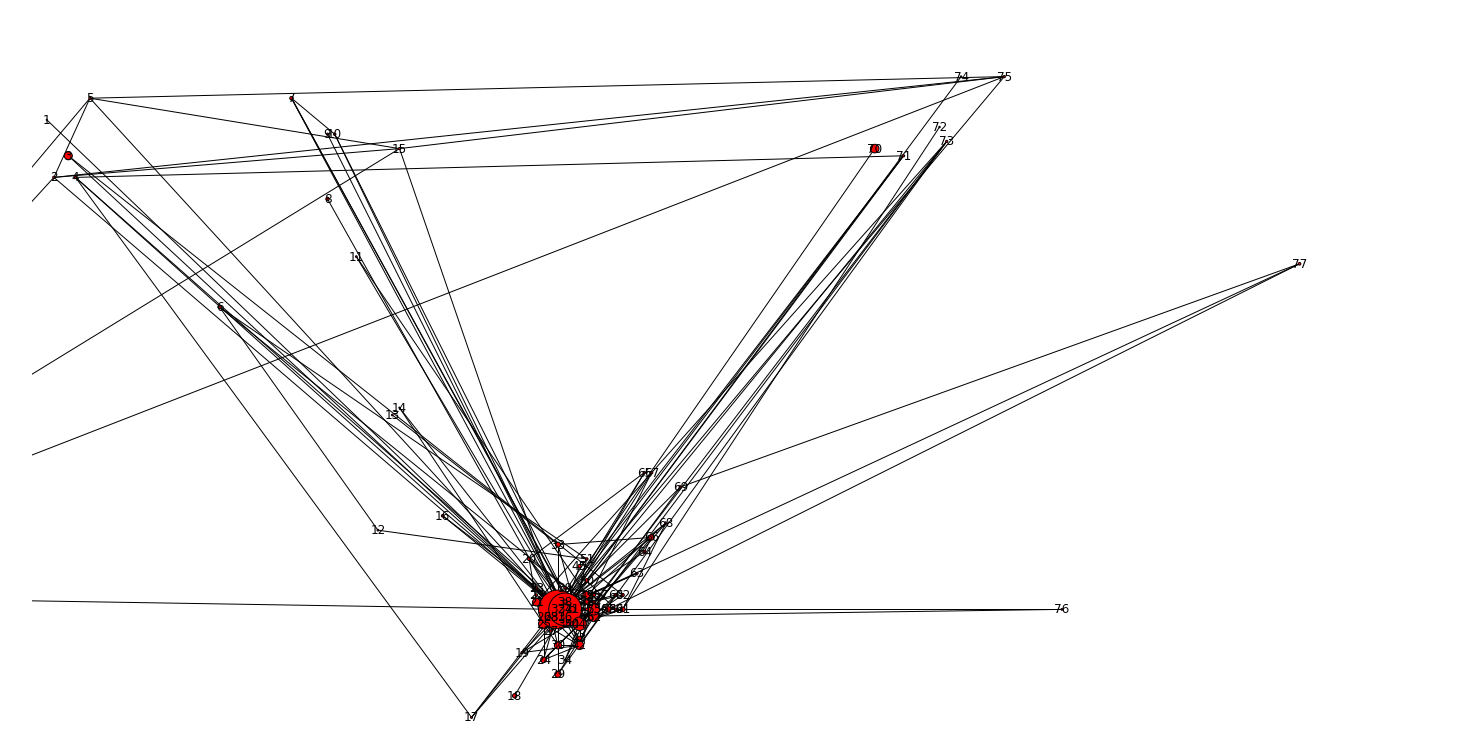

In [170]:
d = nx.degree(x, weight='weight')

plt.figure(figsize=(20,10))

# plt.gca().set_aspect('equal')

nx.draw(x, nx.get_node_attributes(x, 'pos'), with_labels=True, node_size=[v for v in d.values()])
plt.xlim(-125, 75)
plt.ylim(-40, 60)
plt.savefig('Landrina_int_nw.png', transparent=True)
plt.show()

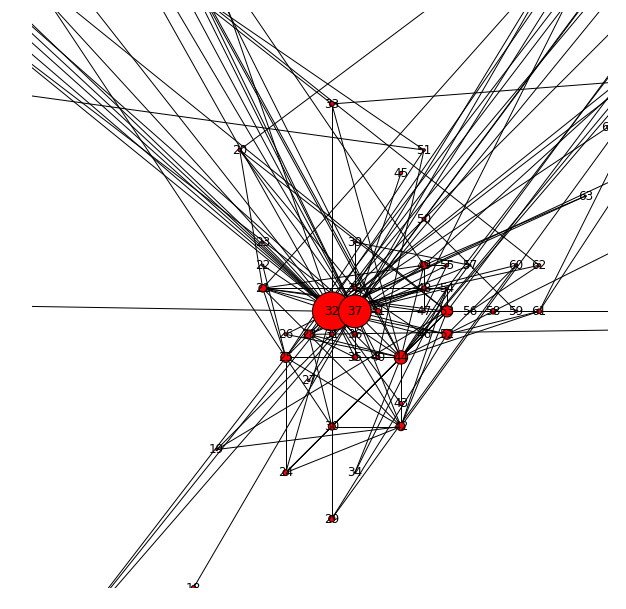

In [177]:
d = nx.degree(x, weight='weight')

plt.figure(figsize=(8,8))

# plt.gca().set_aspect('equal')

nx.draw(x, nx.get_node_attributes(x, 'pos'), with_labels=True, node_size=[v for v in d.values()])
plt.xlim(-65, -40)
plt.ylim(-35, -10)
plt.savefig('Landrina_bra_nw.png', transparent=True)
plt.show()

In [172]:
institutions.loc[institutions.id_y == 1]

,Affiliation,id_y,lng,lat,Area_L2,Area_L1,Country
503,"Biomaterials and Biomechanics, Oregon Health ...",1,-123.0,45.0,Multnomah County,OR,US


In [213]:
# g.nodes(data = True)
Ctry_cent = pd.DataFrame.from_dict(nx.load_centrality(build_graph(nk_data, 'Country')), orient='index').reset_index()
Ctry_cent.columns = [['Country','Country_load_centrality']]

Loc_cent = pd.DataFrame.from_dict(nx.load_centrality(build_graph(nk_data, 'id_y')), orient='index').reset_index()
Loc_cent.columns = [['id_y','Location_load_centrality']]

nk_data = nk_data.merge(Ctry_cent).merge(Loc_cent)

Loc_cent.merge(institutions[['Affiliation','id_y','Area_L1','Country']], how = 'inner').groupby('id_y').first().sort_values(by = 'Location_load_centrality', ascending=False)
Loc_cent.sort_values(by = 'Location_load_centrality', ascending=False)

,id_y,Location_load_centrality
250,257,0.133487
73,76,0.116782
10,11,0.062774
58,61,0.061471
67,70,0.059502
107,111,0.055925
51,53,0.048986
161,167,0.045981
57,60,0.044934
23,24,0.042434


In [120]:
H = nx.Graph()

H.add_nodes_from(nk_data['Author'], bipartite = 0) # Add the node attribute "bipartite"
H.add_nodes_from(nk_data['inst_id'], bipartite=1)

H.add_edges_from([(row['Author'], row['inst_id'], dict(row[['Paper_id','Year', 'Cited by', 'Words_filt', 'lng', 'lat']])) 
                  for i, row in nk_data.iterrows()])

#Aggregate for getting node atts on both sides

In [ ]:
# grouped = nk_data.groupby('Paper_id')
# G = nx.Graph()
# G.add_nodes_from(nk_data['Author'])

# for name, group in grouped:
#     if len(grouped['Author'].apply(list)) > 1:
#         H.add_edges_from([(row['Author'], row['Affiliation'], dict(row[['Paper_id','Year', 'Cited by', 'Words_filt']])) 

        
#         G.add_edges_from(list(itertools.combinations(grouped['Author'].apply(list), 2)), paper_id = grouped['Paper_id'],
#                          cited_by = grouped['Cited by'], year = grouped['Year'], words = grouped['Words_filt'])

### Build network of authors

In [ ]:
entry_dict = [dict(row[['Authors_list', 'Year', 'Cited by', 'Words_filt','Paper_id']]) for index, row in df.iterrows()]

G = nx.Graph()
for entry in entry_dict:
    if len(entry['Authors_list']) > 1:
        G.add_nodes_from(entry['Authors_list'])
        G.add_edges_from(list(itertools.combinations(entry['Authors_list'], 2)), paper_id = entry['Paper_id'],
                         cited_by = entry['Cited by'], year = entry['Year'], words = entry['Words_filt'])
        

In [ ]:
l = []
for n in G.nodes_iter():
    aut_pap = []
    for (u, v, data) in G.edges_iter(n, data=True):
        aut_pap.append(data['paper_id'])
        
    l.append((n, list(set(aut_pap))))
    
nodedata = pd.DataFrame(columns = ['Node','Cited by','Words_filt'])

def most_common(lst):
    return sorted(set(lst), key=lst.count, reverse=True)[:10]

for node in l:
    f = df.loc[df['Paper_id'].isin(node[1])][['Cited by','Words_filt']]
    fd = pd.Series(node[0], index=['Node']).append(f.sum())
    fd['Words_filt'] = most_common(fd['Words_filt'])
    nodedata = nodedata.append(fd, ignore_index=True)   

In [ ]:
#For all edges, all the connections with which we should intersect bag of words.

connect = [[x for x in G.edges(e[0], data = 'group') if x[2] != e[2]] +
        [x for x in G.edges(e[1], data = 'group') if x[2] != e[2]] for e in G.edges_iter(data = 'group')]

In [ ]:
#bag of words intersection

n = len(df)
bags = [set([word for word in abst.lower().split() if word not in stopwords.words('english')]) 
        for abst in df['Abstract']]
# bags = [[word for word in b if word not in stopwords.words('english')] for b in bags]
M = [[bags[i].intersection(bags[j])
   for j in range(n) if j > i]
  for i in range(n)]

In [ ]:
thefile = open('test.txt', 'w')

for item in sorted(G2.nodes()):
  thefile.write("%s\n" % item)

### Tests with binet

In [ ]:
import binet as bt

In [ ]:
# bt.trade_data()

In [ ]:
#There are 4 classes of graph: gGraph, BiGraph, mcp, tnet

g = bt.gGraph()

g.add_nodes_from(nk_data['Author'], bipartite = 0) # Add the node attribute "bipartite"
g.add_nodes_from(nk_data['Affiliation'], bipartite=1)

g.add_edges_from([(row['Author'], row['Affiliation'], dict(row[['Paper_id','Year', 'Cited by', 'Words_filt']])) 
                  for i, row in nk_data.iterrows()])

In [ ]:
#There are 4 classes of graph: gGraph, BiGraph, mcp, tnet

g = bt.BiGraph()

g.add_nodes_from(nk_data['Author'], 0) # Add the node attribute "bipartite"
g.add_nodes_from(nk_data['Affiliation'], 1)

# g.add_edges_from([(row['Author'], row['Affiliation'], dict(row[['Paper_id','Year', 'Cited by', 'Words_filt']])) 
#                   for i, row in nk_data.iterrows()])

g.add_edges_from([(row['Author'], row['Affiliation']) 
                  for i, row in nk_data.iterrows()])

In [ ]:
g = bt.mcp(c = 'Auth', p = 'Affil', data = nk_data[['Author','Affiliation','Paper_id']])
#         nodes_c,nodes_p : pandas DataFrame
#             Node data for each side. The first column must be the node key as it appears in data.

In [ ]:
g.CalculateComplexity()

In [ ]:
# g.nodes(1, as_df = True).sort_values(by = 1)
g._check_side(1)

### Google Maps API calls